# Lab 6.2: Linear Regression

In [1]:
%pylab inline

import pandas as pd
import statsmodels.api as sm
import yaml

from seaborn import pairplot
from sqlalchemy import create_engine

pg_creds = yaml.load(open('../../pg_creds.yaml'))['student']

engine = create_engine('postgresql://{user}:{password}@{host}:{port}/{dbname}'.format(**pg_creds))

Populating the interactive namespace from numpy and matplotlib


**Question 1**  

Using the cars data,

1) Fit a simple linear regression to predict `mpg` using `weight`.  

In [2]:
cars = pd.read_sql("SELECT * FROM cars WHERE horsepower IS NOT NULL;", engine, index_col='index')

In [3]:
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
index,,,,,,,,,
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [4]:
X = cars.weight
X = sm.add_constant(X)
y = cars.mpg

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     878.8
Date:                Tue, 04 Oct 2016   Prob (F-statistic):          6.02e-102
Time:                        15:13:13   Log-Likelihood:                -1130.0
No. Observations:                 392   AIC:                             2264.
Df Residuals:                     390   BIC:                             2272.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         46.2165      0.799     57.867      0.000        44.646    47.787
weight        -0.0076      0.000    -29.645      0.000        -0.008    -0.007
==============================================================================
Omnibus:                       41.682   Durbin-Watson:                   0.808
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.039
Skew:                           0.727   Prob(JB):                     9.18e-14
Kurtosis:                       4.251   Cond. No.                     1.13e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$\hat{mpg} = 46.2165 - 0.0076 * weight$

2) Comment on the model fit.  

The percentage of the variation in y (mpg) can be explained by the corresponding variation in X (weight) and the least-squares line is 69.3%, and the unexplained percentage of variation is 100% – 69.3% = 30.7%.

3) Interpret the model. 

Every unit of increase in weight affects the mpg by -0.0076.

4) Is `weight` useful for predicting `mpg`? Carry out a formal hypothesis test to show it.  

$H_0: \beta_1 = 0$  

$H_a: \beta_1 \neq 0$ 

The p-value is 0 (6.02e-102 to be exact) which is less than 0.05, so we reject the null hypothesis and conclude that the coefficient of weight is significant.

5) Make a prediction for the average `mpg` of all cars that have a weight of 2000.  

In [5]:
46.2165 - 0.0076473 * 2000

30.9219

In [6]:
results.predict([1, 2000])

array([ 30.92183948])

6) Make a prediction for a particular car that has a weight of 2000.  

It's exactly as above:

In [7]:
46.2165 - 0.0076473 * 2000

30.9219

>For both the given population of all cars with weight of 2000, the mean is the same as one car of weight 2000. HOWEVER, the variance for the given population of all cars with weight of 2000 is $\sigma^2/n$, when the variance for the one car of weight 2000 is $\sigma^2$, which is more than the variance for the given population of all cars with weight of 2000.

7) Write a Python function to calculate the confidence interval for your prediction in part 5).  

In [8]:
x = cars.weight
se = sqrt(results.mse_resid)
b0, b1 = results.params

x_new = 2000

def confidence_se(s_e, x, x_new):
    mean_x = x.mean()
    var_x = x.var()
    n = len(x)
    return s_e * (1/n + (x_new - mean_x)**2 / ((n - 1) * var_x))**0.5

sign = array([-1., 1.])
b0 + b1 * x_new + sign * 1.96 * confidence_se(se, x, x_new)

array([ 30.26741098,  31.57626797])

8) Write a Python function to calculate the prediction interval for your prediction in part 6).  

In [9]:
def prediction_se(s_e, x, x_new):
    mean_x = x.mean()
    var_x = x.var()
    n = len(x)
    return s_e * (1 + 1/n + (x_new - mean_x)**2 / ((n - 1) * var_x))**0.5

b0 + b1 * x_new + sign * 1.96 * prediction_se(se, x, x_new)

array([ 22.40454496,  39.439134  ])

9) What are the differences between the intervals you found in parts 7) and 8)?

For both the given population of all cars with weight of 2000, the mean is the same as one car of weight 2000. HOWEVER, the variance for the given population of all cars with weight of 2000 is $\sigma^2/n$, when the variance for the one car of weight 2000 is $\sigma^2$, which is more than the variance for the given population of all cars with weight of 2000. THEREFORE, the confidence interval for the given population of all cars with weight of 2000 is smaller than the prediction interval for the one car of weight 2000.

<img src="images/conf_pred.png" width="600">  

**Question 2**  

You are shopping for a laptop computer at Best Buy. To help you with your decision, you decide to construct a regression model to predict the selling price of the laptop. The table `laptops` provides the following data for a random sample of laptops on Best Buy’s Web site:  

* Selling price
* Brand
* Screen size (in.)
* Hard drive size (GB)
* Amount of RAM memory (GB)
* Number of USB ports
* Weight (oz.) 

a) Using multiple regression, model selling price using the variables screen size, hard drive size, amount of ram, number of usb ports and weight.  

In [10]:
laptops = pd.read_sql("SELECT * FROM laptops;", engine)

In [11]:
laptops.head()

,Price ($),Screen Size (in.),RAM Memory (GB),Hard drive (GB),USB Ports,Brand,Weight (oz.)
0,830,13.3,4,500,3,Toshiba,4.9
1,750,13.3,4,640,3,Toshiba,3.2
2,1200,11.6,2,128,2,Apple,2.3
3,1600,18.4,6,640,4,Toshiba,9.7
4,1900,18.4,8,500,4,Toshiba,9.7


In [12]:
# Lowercase and replace periods & spaces in the column names
new_names = []

for col in laptops.columns:
    new_names.append(col.replace('.', '', len(col)).replace(' ', '', len(col)).lower())

laptops.columns = new_names

print(laptops.columns)

Index(['price($)', 'screensize(in)', 'rammemory(gb)', 'harddrive(gb)',
       'usbports', 'brand', 'weight(oz)'],
      dtype='object')


In [13]:
X_multi = laptops[['screensize(in)', 'rammemory(gb)', 'harddrive(gb)', 'usbports', 'weight(oz)']]
X_multi = sm.add_constant(X_multi)
y_multi = laptops['price($)']

model_multi = sm.OLS(y_multi, X_multi)
results_multi = model_multi.fit()
results_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               price($)   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1.514
Date:                Tue, 04 Oct 2016   Prob (F-statistic):              0.200
Time:                        15:13:14   Log-Likelihood:                -477.99
No. Observations:                  63   AIC:                             968.0
Df Residuals:                      57   BIC:                             980.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const            761.4987    946.954      0.804      0.425     -1134.744  2657.741
screensize(in)     4.1113     96.206      0.043      0.966      -188.539   196.761
rammemory(gb)     12.8642     74.411      0.173      0.863      -136.141   161.870
harddrive(gb)      0.6561      0.459      1.429      0.159        -0.263     1.576
usbports        -206.5346    123.563     -1.671      0.100      -453.965    40.896
weight(oz)        51.6251     99.210      0.520      0.605      -147.040   250.290
==============================================================================
Omnibus:                        9.835   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.384
Skew:                           0.993   Prob(JB):                      0.00556
Kurtosis:                       3.102   Cond. No.                     8.40e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$\hat{price} = 761.4987 + 4.1113 * screensize + 12.8642 * memory + 0.6561 * harddrive - 206.5346 * usb + weight * 51.6251$

b) Perform and interpret the overall F test.  

F-statistic:	1.514

Prob (F-statistic):	0.200

The overall model is very bad: the overall p-value is 0.2, which is larger than 0.05. Also, the F-statistic is very low (1.514).

We are using too many independent variables to build the model.

c) Using p-values, which variables appear to be needed in the model? Justify your answer.   

In [27]:
laptops[['screensize(in)', 'rammemory(gb)', 'harddrive(gb)', 'usbports', 'weight(oz)']].corr()

,screensize(in),rammemory(gb),harddrive(gb),usbports,weight(oz)
screensize(in),1.000000,0.646148,0.560412,0.638097,0.895285
rammemory(gb),0.646148,1.000000,0.786727,0.533892,0.642392
harddrive(gb),0.560412,0.786727,1.000000,0.540018,0.552018
usbports,0.638097,0.533892,0.540018,1.000000,0.585799
weight(oz),0.895285,0.642392,0.552018,0.585799,1.000000


All p-values are high, however, if we have to discard some variables based on p-value, and with the help of the above correlation table, we would discard weight, ram memory and screen size as they are highly correlated.

Besides weight, ram memory and screen size have the worst p-values: 0.605, 0.863 and 0.966 respectively.

So, we decide to keep usb ports and hard drive.

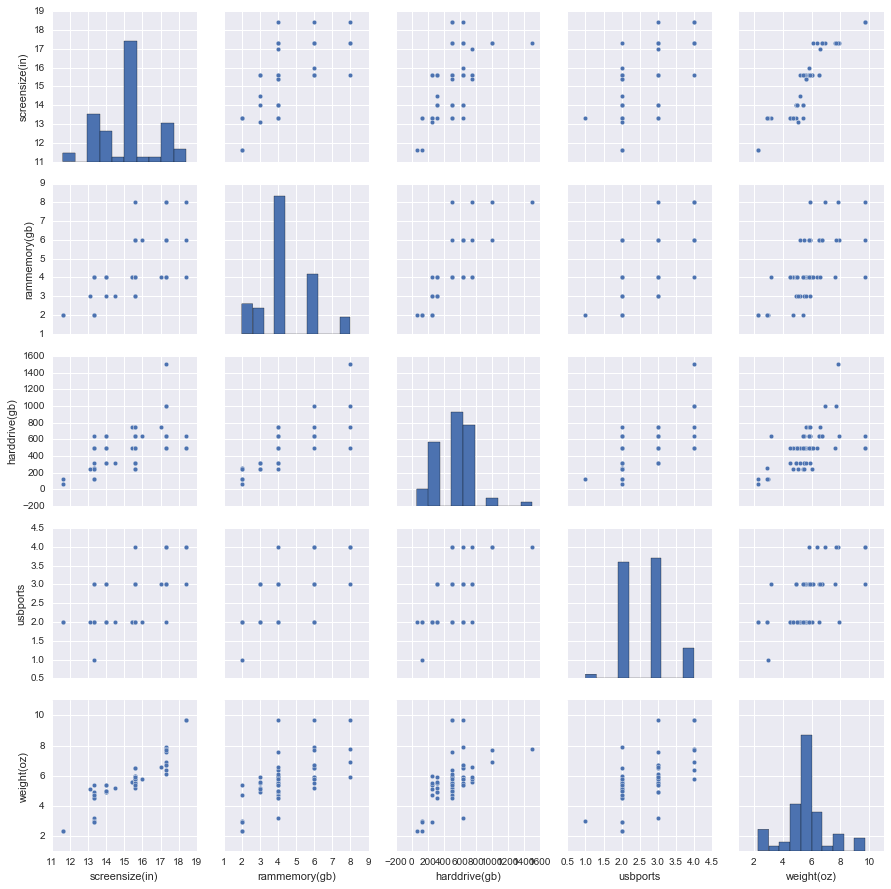

In [28]:
XX = laptops[['screensize(in)', 'rammemory(gb)', 'harddrive(gb)', 'usbports', 'weight(oz)']]
pairplot(XX);

d) Now create a new predictor that contains random numbers drawn from your favorite distribution, and include this predictor in your multiple regression model. Comment on the model fit. How does the new $R^2$ compare to the one in part a)?  

In [14]:
mu, sigma = 0, 1
# We choose size equal to the size of the dataframe.
new_predictor = np.random.normal(mu, sigma, len(laptops))

In [15]:
laptops['new_predictor'] = new_predictor

In [16]:
laptops.head()

,price($),screensize(in),rammemory(gb),harddrive(gb),usbports,brand,weight(oz),new_predictor
0,830,13.3,4,500,3,Toshiba,4.9,0.711356
1,750,13.3,4,640,3,Toshiba,3.2,0.845838
2,1200,11.6,2,128,2,Apple,2.3,0.356981
3,1600,18.4,6,640,4,Toshiba,9.7,-2.353277
4,1900,18.4,8,500,4,Toshiba,9.7,-0.203527


In [17]:
X_multi_new = laptops[['screensize(in)', 'rammemory(gb)', 'harddrive(gb)', 'usbports', 'weight(oz)', 'new_predictor']]
X_multi_new = sm.add_constant(X_multi_new)
y_multi_new = laptops['price($)']

model_multi_new = sm.OLS(y_multi_new, X_multi_new)
results_multi_new = model_multi_new.fit()
results_multi_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               price($)   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1.244
Date:                Tue, 04 Oct 2016   Prob (F-statistic):              0.298
Time:                        15:13:14   Log-Likelihood:                -477.98
No. Observations:                  63   AIC:                             970.0
Df Residuals:                      56   BIC:                             985.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const            767.4678    955.983      0.803      0.425     -1147.596  2682.532
screensize(in)     4.3411     97.053      0.045      0.964      -190.080   198.762
rammemory(gb)     11.8266     75.367      0.157      0.876      -139.152   162.805
harddrive(gb)      0.6709      0.473      1.417      0.162        -0.277     1.619
usbports        -209.5735    126.231     -1.660      0.102      -462.446    43.299
weight(oz)        50.7794    100.226      0.507      0.614      -149.998   251.557
new_predictor     -8.9471     58.909     -0.152      0.880      -126.956   109.062
==============================================================================
Omnibus:                        9.869   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.416
Skew:                           0.995   Prob(JB):                      0.00547
Kurtosis:                       3.109   Cond. No.                     8.40e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Even though $R^2$ is slightly better (0.118) than initially (0.117), in fact we should be looking at the adjusted R squared, which is worse now (0.023) than initially (0.04): so this model is worse.

Also, to confirm that this new model is worse than the initial, the F-statistic is now 1.244, less than 1.514 of the initial value. The p-value of the new model is also worse (0.298) than the initial model (0.2).

e) Generate another new predictor - you can draw another list of random numbers from the same distribution as above, or you can draw from a different distribution. Add this predictor to the model in part d). What happends to the $R^2$? Does this mean that the new predictor is useful for predicting laptop prices?

In [18]:
lambda_predictor = 2
# We choose size equal to the size of the dataframe.
another_predictor = np.random.exponential(lambda_predictor, len(laptops))

In [19]:
laptops['another_predictor'] = another_predictor

In [20]:
laptops.head()

,price($),screensize(in),rammemory(gb),harddrive(gb),usbports,brand,weight(oz),new_predictor,another_predictor
0,830,13.3,4,500,3,Toshiba,4.9,0.711356,2.016779
1,750,13.3,4,640,3,Toshiba,3.2,0.845838,0.275248
2,1200,11.6,2,128,2,Apple,2.3,0.356981,0.700892
3,1600,18.4,6,640,4,Toshiba,9.7,-2.353277,0.599243
4,1900,18.4,8,500,4,Toshiba,9.7,-0.203527,0.755562


In [21]:
X_multi_another = laptops[['screensize(in)', 'rammemory(gb)', 'harddrive(gb)', 'usbports', 'weight(oz)', 'new_predictor', 'another_predictor']]
X_multi_another = sm.add_constant(X_multi_another)
y_multi_another = laptops['price($)']

model_multi_another = sm.OLS(y_multi_another, X_multi_another)
results_multi_another = model_multi_another.fit()
results_multi_another.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               price($)   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.053
Date:                Tue, 04 Oct 2016   Prob (F-statistic):              0.406
Time:                        15:13:14   Log-Likelihood:                -477.96
No. Observations:                  63   AIC:                             971.9
Df Residuals:                      55   BIC:                             989.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const               764.9227    964.400      0.793      0.431     -1167.779  2697.624
screensize(in)        5.7500     98.172      0.059      0.954      -190.991   202.491
rammemory(gb)        13.1709     76.344      0.173      0.864      -139.825   166.167
harddrive(gb)         0.6514      0.488      1.335      0.187        -0.327     1.630
usbports           -208.1326    127.551     -1.632      0.108      -463.750    47.485
weight(oz)           49.9236    101.197      0.493      0.624      -152.879   252.727
new_predictor        -9.8068     59.590     -0.165      0.870      -129.228   109.614
another_predictor    -8.7997     45.706     -0.193      0.848      -100.396    82.796
==============================================================================
Omnibus:                        9.762   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               10.278
Skew:                           0.988   Prob(JB):                      0.00586
Kurtosis:                       3.105   Cond. No.                     8.40e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Actually, adding a new variable make the model even worse:
    
$R^2$ = 0.118

Adjusted R square: 0.006

F-statistic: 1.053

Model p-value: 0.406

Overall, this is the worse of the 3 models.

**Question 3**  

Squirt Squad is a cleaning service that sends crews to residential homes on either a once-a-month or twice-a-month schedule, depending on the customer’s preference. The owner would like to predict the amount of time required to clean a house based on the square footage of the house, the total number of rooms in the house, the number of bathrooms it has, the size of the cleaning crew, the frequency of the cleaning schedule, and whether or not the household has children. Data can be found in the tables **`squad`** (containing `squad_id`, `home_id`, `crew` and `freq` (0: once-a-month, 1: twice-a-month); **`squad_homes`** (containing `home_id`, `footage`, `rooms`, `baths` and `children` (Squirt Squad assumes the number of children in a house will never change. BONUS: how would you change the schema to account for the possibility that it will?)); and **`squad_times`** (containing `squad_id` and `dt`, `time` and `crew` (redundant with `squad` but included in case the squad size changes)). You will need to construct a three-way join using `home_id` and `squad_id`.

a) Construct a regression model using all of the independent variables.  

We would create a lookup table to store the number of children by threshold:

0 - 0 children

1 - 1 to 2 children

2 - 3 to 5 children

3 - more than 5 children

and join the new table based on home_id.

In [29]:
squad = pd.read_sql("SELECT s.squad_id, s.home_id, s.crew, s.freq, sh.footage,sh.rooms, sh.baths, sh.children, st.dt, st.time FROM squad AS s INNER JOIN squad_homes AS sh ON s.home_id = sh.home_id INNER JOIN squad_times AS st ON s.squad_id = st.squad_id;", engine)

In [30]:
squad.head()

,squad_id,home_id,crew,freq,footage,rooms,baths,children,dt,time
0,1,0,3,1,1548,8,2.0,0,2016-09-17,132
1,2,1,2,1,1599,7,1.5,0,2016-09-09,146
2,3,2,3,1,1630,8,2.0,0,2016-09-12,131
3,4,3,3,1,1640,7,1.5,0,2016-09-11,141
4,5,4,3,0,1711,8,2.5,1,2016-09-27,144


In [31]:
X_squad = squad[['crew', 'freq', 'footage', 'rooms', 'baths', 'children']]
X_squad = sm.add_constant(X_squad)
y_squad = squad['time']

model_squad = sm.OLS(y_squad, X_squad)
results_squad = model_squad.fit()
results_squad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     44.51
Date:                Tue, 04 Oct 2016   Prob (F-statistic):           1.02e-37
Time:                        15:42:37   Log-Likelihood:                -1222.2
No. Observations:                 278   AIC:                             2458.
Df Residuals:                     271   BIC:                             2484.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        143.5146     10.950     13.106      0.000       121.956   165.073
crew         -15.4141      2.026     -7.609      0.000       -19.402   -11.426
freq          -4.0902      2.621     -1.561      0.120        -9.250     1.070
footage       -0.0048      0.006     -0.772      0.441        -0.017     0.007
rooms          6.7580      1.238      5.457      0.000         4.320     9.196
baths         -5.6072      3.247     -1.727      0.085       -12.000     0.786
children      22.8734      2.618      8.738      0.000        17.720    28.027
==============================================================================
Omnibus:                        3.347   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.188   Jarque-Bera (JB):                3.313
Skew:                          -0.148   Prob(JB):                        0.191
Kurtosis:                       3.446   Cond. No.                     2.27e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$\hat{time} = 143.5146 - crew * 15.4141 - frequency * 4.0902 - footage * 0.0048 + rooms * 6.7580 - baths * 5.6072 + children * 22.8734$

b) Test and interpret the significance of the overall regression model (what is the result of the overall F test)?  

F-statistic: 44.51

Overall model p-value: 1.02e-37

The p-value is almost 0, less than 0.05, so it is significant.

c) Interpret the meaning of the regression coefficient for the Rooms, Crew, Children, and Frequency variables.  

For every unit in increase of crew, time decreases by 15.4141 units.

For every unit in increase of frequency, time decreases by 4.0902 units.

For every unit in increase of rooms, time increases by 6.7580 units.

For every unit in increase of children, time increases by 22.8734 units.

d) Using the p-values, identify which independent variables are significant (needed).  

crew, rooms and children have p-values of 0, which is less than 0.05 and therefore are significant.

The other variables (frequency, footage and baths) are not significant because their p-values are higher than 0.05.

e) Construct a regression model using only the significant variables found in part d) and predict the average time to clean a house that has 2,250 square feet, 11 total rooms, 3.5 bathrooms, and no children. This house is cleaned once a month with a crew of four employees.  

In [35]:
X_squad = squad[['crew', 'rooms', 'children']]
X_squad = sm.add_constant(X_squad)
y_squad = squad['time']

model_squad = sm.OLS(y_squad, X_squad)
results_squad = model_squad.fit()
results_squad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     83.83
Date:                Tue, 04 Oct 2016   Prob (F-statistic):           1.66e-38
Time:                        15:55:05   Log-Likelihood:                -1227.0
No. Observations:                 278   AIC:                             2462.
Df Residuals:                     274   BIC:                             2476.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        143.6367      9.301     15.443      0.000       125.326   161.948
crew         -15.9710      2.013     -7.932      0.000       -19.935   -12.007
rooms          3.9412      0.553      7.131      0.000         2.853     5.029
children      23.4329      2.476      9.463      0.000        18.558    28.308
==============================================================================
Omnibus:                        3.224   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.200   Jarque-Bera (JB):                3.434
Skew:                          -0.094   Prob(JB):                        0.180
Kurtosis:                       3.511   Cond. No.                         90.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$\hat{time} = 143.6367 - crew * 15.9710 + rooms * 3.9412 + children * 23.4329$

In [41]:
time = 143.6367 - (4 * 15.9710) + (11 * 3.9412) + (0 * 23.4329)

print("Time to clean is:", round(time, 2))

Time to clean is: 123.11


**NOTE**

The exercise wants to use bathrooms and square footage, which we had excluded as the p-values were too high. We are going to build a new model including them.

In [42]:
X_squad_more = squad[['crew', 'rooms', 'children', 'footage', 'baths']]
X_squad_more = sm.add_constant(X_squad_more)
y_squad_more = squad['time']

model_squad_more = sm.OLS(y_squad_more, X_squad_more)
results_squad_more = model_squad_more.fit()
results_squad_more.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     52.65
Date:                Tue, 04 Oct 2016   Prob (F-statistic):           4.41e-38
Time:                        17:09:03   Log-Likelihood:                -1223.4
No. Observations:                 278   AIC:                             2459.
Df Residuals:                     272   BIC:                             2481.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        141.0494     10.864     12.983      0.000       119.660   162.438
crew         -15.5720      2.028     -7.677      0.000       -19.565   -11.579
rooms          6.8612      1.240      5.534      0.000         4.420     9.302
children      24.2347      2.475      9.793      0.000        19.363    29.107
footage       -0.0047      0.006     -0.762      0.447        -0.017     0.007
baths         -6.0441      3.244     -1.863      0.063       -12.430     0.342
==============================================================================
Omnibus:                        4.135   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.127   Jarque-Bera (JB):                4.579
Skew:                          -0.136   Prob(JB):                        0.101
Kurtosis:                       3.567   Cond. No.                     2.25e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$\hat{time} = 141.0494 - crew * 15.5720 + rooms * 6.8612 + children * 24.2347 - footage * 0.0047 - baths * 6.0441$

In [43]:
time = 141.0494 - (4 * 15.5720) + (11 * 6.8612) - (2250 * 0.0047) - (3.5 * 6.0441) + (0 * 24.2347)

print("Time to clean is:", round(time, 2))

Time to clean is: 122.51


The time above is not very different from the one calculated before (123.11).

f) Compare the two models you fitted, which one is a better model? Why?

<u>Initial model (all variables):</u>

$R^2$ = 0.496

Adjusted R squared = 0.485

F-stat = 44.51

Overall model p-value = 1.02e-37

<u>Second model (using crew, rooms and children):</u>

$R^2$ = 0.479

Adjusted R squared = 0.473

F-stat = 88.83

Overall model p-value = 1.66e-38

<u>Third model (using crew, rooms, children, footage and bathrooms):</u>

$R^2$ = 0.492

Adjusted R squared = 0.482

F-stat = 52.65

Overall model p-value = 4.41e-38

==================

We prefer the model using crew, rooms and children because it has the highest F-stats and a very low p-value, practically 0.

The adjusted R squared are very similar for all models, so we don't think it makes a big difference.